# change to 3 class classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from collections import Counter
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, KFold

In [2]:
def write_auc(config, roc_auc):
    file = write_path+'BDT_results.txt'
    with open(file, 'a+') as f:
        aucs = []
        for i in range(0, 3):
            aucs.append(roc_auc[i])
        auc_msg = ','.join(map(str, aucs))
        message = f'{config}; {auc_msg} \n'
        f.write(message)

In [3]:
def write_cm(config, cm_p, cm_e):
    file = write_path+'BDT_cm.txt'
    with open(file, 'a+') as f:
        cm_p_msg = ','.join(map(str, cm_p.flatten().tolist()))
        cm_e_msg = ','.join(map(str, cm_e.flatten().tolist()))
        message = f'{config}; {cm_p_msg}; {cm_e_msg} \n'
        f.write(message)

In [4]:
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    plt.legend()

In [5]:
def plot_confusion_matrix(y_test, y_pred, classes, figname, w_test=None, normalise_by_col=False, normalise_by_row=False, cmap=plt.cm.Blues):
    if w_test is not None: cm = confusion_matrix(y_test, y_pred, sample_weight=w_test)
    else: cm = confusion_matrix(y_test, y_pred) 
    if normalise_by_col:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print ('Normalised efficiency confusion matrix')
    elif normalise_by_row:
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
        print ('Normalised purity confusion matrix')
    else:
        print ('Non-normalised confusion matrix')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='w' if cm[i, j] > thresh else 'k')

    plt.tight_layout(pad=1.4)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(figname)
    print ('Confusion matrix saved as {}'.format(figname))
    return cm

In [6]:
path = '/vols/cms/dw515/Offline/output/SM/masters_signal_vs_background_combined/'
write_path = '/home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/'

In [7]:
vbfh_tree = uproot.open(path+'VBFH.root')['ntuple']
ztt_tree = uproot.open(path+'ZTT.root')['ntuple']
fakes_tree = uproot.open(path+'fakes.root')['ntuple']
ggh_tree = uproot.open(path+'ggH.root')['ntuple']

In [8]:
variables = ['pt_1','pt_2', 'm_vis','svfit_mass','mjj','jpt_1','pt_tt','met','n_jets','pt_vis','iso_1','iso_2', 'wt']
selectors = ['rand', 'wt_cp_sm', 'deepTauVsJets_medium_1', 'deepTauVsJets_medium_2', 'trg_doubletau', 'os']

In [9]:
vbfh = vbfh_tree.pandas.df(variables+selectors)
ztt = ztt_tree.pandas.df(variables+selectors)
fakes = fakes_tree.pandas.df(variables+selectors)
ggh = ggh_tree.pandas.df(variables+selectors)

In [10]:
vbfh = vbfh[vbfh['deepTauVsJets_medium_1'] & vbfh['deepTauVsJets_medium_2'] & vbfh['trg_doubletau'] & vbfh['os']]
ztt = ztt[ztt['deepTauVsJets_medium_1'] & ztt['deepTauVsJets_medium_2'] & ztt['trg_doubletau'] & ztt['os']]
fakes = fakes[fakes['deepTauVsJets_medium_1'] & fakes['deepTauVsJets_medium_2'] & fakes['trg_doubletau'] & (fakes['os']==0)]
ggh = ggh[ggh['deepTauVsJets_medium_1'] & ggh['deepTauVsJets_medium_2'] & ggh['trg_doubletau'] & ggh['os']]

In [11]:
scaling = {
    'ggh': 0.0022034,
    'vbfh': 0.0001486,
    'fakes': 1.35,
    'ztt': 3.6292,
}

In [12]:
vbfh.loc[:, 'w'] = vbfh.wt*vbfh.wt_cp_sm *scaling['vbfh']
ztt.loc[:, 'w'] = ztt.wt *scaling['ztt']
fakes.loc[:, 'w'] = fakes.wt *scaling['fakes']
ggh.loc[:, 'w'] = ggh.wt*ggh.wt_cp_sm *scaling['ggh']

In [13]:
higgs = pd.concat([vbfh, ggh]).reset_index(drop=True)

In [14]:
higgs.loc[:, 'y'] = np.zeros(higgs.shape[0])
ztt.loc[:, 'y'] = np.ones(ztt.shape[0])
fakes.loc[:, 'y'] = np.full((fakes.shape[0],),2.)

In [15]:
higgs.loc[:, 'cn'] = np.full((higgs.shape[0],),928.278)
ztt.loc[:, 'cn'] = np.full((ztt.shape[0],),4.716)
fakes.loc[:, 'cn'] = np.full((fakes.shape[0],),1.278)

In [16]:
df = pd.concat([higgs, ztt, fakes]).reset_index(drop=True)

In [39]:
df.cn

0          928.278
1          928.278
2          928.278
3          928.278
4          928.278
            ...   
1397837      1.278
1397838      1.278
1397839      1.278
1397840      1.278
1397841      1.278
Name: cn, Length: 1397054, dtype: float64

In [18]:
df = df[df.w > 0]

In [19]:
print(sorted(Counter(df.y).items()))

[(0.0, 1262736), (1.0, 33487), (2.0, 100831)]


In [20]:
higgs.w.sum(), ztt.w.sum(), fakes.w.sum()

(927.8508354332606, 36877.137177970326, 136121.85)

# base case

In [20]:
df_1 = df.drop(selectors+['iso_1', 'iso_2'], axis=1)

In [21]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()


In [22]:
df_1.drop(['y', 'wt', 'w'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis'],
      dtype='object')

In [23]:
X = df_1.drop(['y', 'wt', 'w'], axis=1).to_numpy()
y = df_1.y.astype(int)
w = df_1.w
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.3, random_state=1, stratify=df_1.y)

In [24]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss", sample_weight_eval_set=(w_train, w_test))
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:13:49] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.05058	validation_1-mlogloss:1.05039
[2]	validation_0-mlogloss:0.96629	validation_1-mlogloss:0.96588
[4]	validation_0-mlogloss:0.89499	validation_1-mlogloss:0.89440
[6]	validation_0-mlogloss:0.83402	validation_1-mlogloss:0.83326
[8]	validation_0-mlogloss:0.78139	validation_1-mlogloss:0.78047
[10]	validation_0-mlogloss:0.73575	validation_1-mlogloss:0.73472
[12]	validation_0-mlogloss:0.69607	validation_1-mlogloss:0.69491
[14]	validation_0-mlogloss:0.66123	validation_1-mlogloss:0.66002
[16]	validation_0-mlogloss:0.63078	validation_1-mlogloss:0.62951
[18]	validation_0-mlogloss:0.60383	validation_1-mlogloss:0.60246
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [40]:
# skf = StratifiedKFold(n_splits=5)
# for train, test in skf.split(X, y):
#     xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss", sample_weight_eval_set=(w_train, w_test)

0.25000125721642225
0.24999968569628958
0.24999968569628958
0.24999968569628958
0.24999968569628958


In [25]:
y_pred = xgb_clf.predict_proba(X_test)
onehot=label_binarize(y_test,classes=[0,1,2])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(3):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i],sample_weight=w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

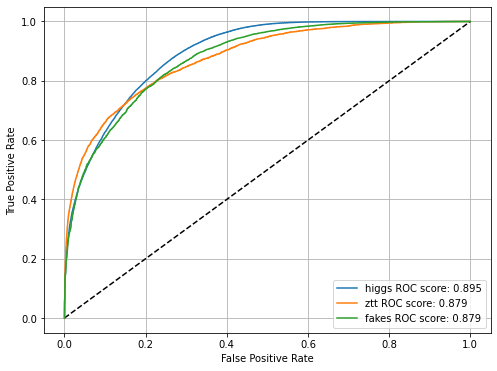

In [26]:
classes = ['higgs', 'ztt', 'fakes']
fig, ax = plt.subplots(figsize=(8,6))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('/signal_background/eda/roc_curves.png')
# 0.792, 0.791, 0.885

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


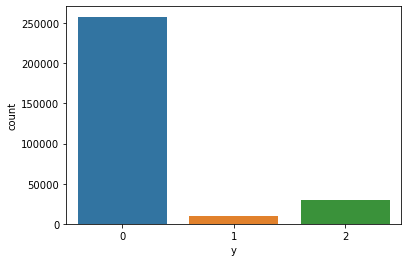

In [28]:
sns.countplot(y_test)
plt.show()

In [27]:
write_auc('base', roc_auc)

In [28]:
cr = classification_report(y_test, xgb_clf.predict(X_test), output_dict=True, target_names=classes, sample_weight=w_test)
pd.DataFrame(cr).transpose()

,precision,recall,f1-score,support
higgs,0.448015,0.052022,0.093219,279.545650
ztt,0.788272,0.506997,0.617094,11039.960088
fakes,0.875051,0.964759,0.917718,40836.150000
accuracy,0.862971,0.862971,0.862971,0.862971
macro avg,0.703779,0.507926,0.542677,52155.655738
weighted avg,0.854393,0.862971,0.849665,52155.655738


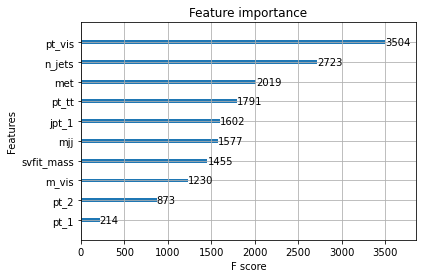

In [29]:
xgboost.plot_importance(xgb_clf).set_yticklabels(df_1.drop(['y','wt','w'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_weight.png')
plt.show()

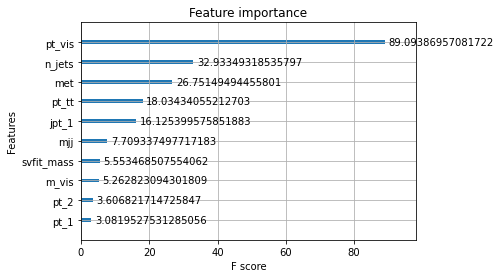

In [30]:
xgboost.plot_importance(xgb_clf, importance_type='gain').set_yticklabels(df_1.drop(['y','wt','w'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_gain.png')
plt.show()

Normalised purity confusion matrix
[[0.44801486 0.00981648 0.00433782]
 [0.38562531 0.78827187 0.12061098]
 [0.16635983 0.20191165 0.8750512 ]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/purity.png
Normalised efficiency confusion matrix
[[5.20217532e-02 2.49344685e-01 6.98633562e-01]
 [1.13381797e-03 5.06997052e-01 4.91869130e-01]
 [1.32235776e-04 3.51085986e-02 9.64759166e-01]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/efficiency.png


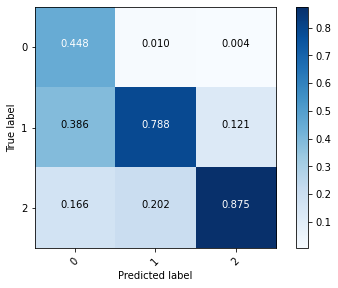

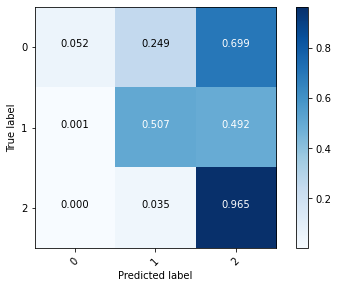

In [31]:
predict=xgb_clf.predict(X_test)
cm_p=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_row=True, w_test=w_test, figname=f'{write_path}purity.png')
cm_e=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_col=True, w_test=w_test, figname=f'{write_path}efficiency.png')

In [32]:
write_cm('base', cm_p, cm_e)

# with iso variables

In [21]:
df_2 = df.drop(selectors, axis=1)

In [22]:
print(sorted(Counter(df_2.y).items()))

[(0.0, 1262736), (1.0, 33487), (2.0, 100831)]


In [23]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf_iso = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()

In [24]:
df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'iso_1', 'iso_2'],
      dtype='object')

In [25]:
X = df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).to_numpy()
y = df_2.y.astype(int)
w = df_2.w
X_train, X_test, y_train, y_test, w_train, w_test, cn_train, cn_test= train_test_split(X, y, w, df.cn, test_size=0.3, random_state=1, stratify=df_2.y)

In [26]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf_iso.fit(X_train, y_train, sample_weight=w_train*cn_train, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set, 
                eval_metric = "mlogloss", sample_weight_eval_set=(w_train*cn_train, w_test*cn_test))
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:30:32] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.05679	validation_1-mlogloss:1.05676
[2]	validation_0-mlogloss:0.98316	validation_1-mlogloss:0.98298
[4]	validation_0-mlogloss:0.92054	validation_1-mlogloss:0.92030
[6]	validation_0-mlogloss:0.86668	validation_1-mlogloss:0.86634
[8]	validation_0-mlogloss:0.82017	validation_1-mlogloss:0.81971
[10]	validation_0-mlogloss:0.77957	validation_1-mlogloss:0.77906
[12]	validation_0-mlogloss:0.74425	validation_1-mlogloss:0.74368
[14]	validation_0-mlogloss:0.71327	validation_1-mlogloss:0.71264
[16]	validation_0-mlogloss:0.68609	validation_1-mlogloss:0.68546
[18]	validation_0-mlogloss:0.66202	validation_1-mlogloss:0.66134
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [42]:
X = df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).to_numpy()
y = df_2.y.astype(int)
w = df_2.w
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.3, random_state=1, stratify=df_2.y)

In [43]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf_iso.fit(X_train, y_train, sample_weight=w_train, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set, 
                eval_metric = "mlogloss", sample_weight_eval_set=(w_train, w_test))

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:50:23] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.04747	validation_1-mlogloss:1.04743
[2]	validation_0-mlogloss:0.95749	validation_1-mlogloss:0.95736
[4]	validation_0-mlogloss:0.88089	validation_1-mlogloss:0.88071
[6]	validation_0-mlogloss:0.81524	validation_1-mlogloss:0.81503
[8]	validation_0-mlogloss:0.75840	validation_1-mlogloss:0.75829
[10]	validation_0-mlogloss:0.70887	validation_1-mlogloss:0.70895
[12]	validation_0-mlogloss:0.66540	validation_1-mlogloss:0.66565
[14]	validation_0-mlogloss:0.62727	validation_1-mlogloss:0.62763
[16]	validation_0-mlogloss:0.59374	validation_1-mlogloss:0.59446
[18]	validation_0-mlogloss:0.56389	validation_1-mlogloss:0.56473
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [44]:
y_pred = xgb_clf_iso.predict_proba(X_test)
onehot=label_binarize(y_test,classes=[0,1,2])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(3):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i],sample_weight=w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

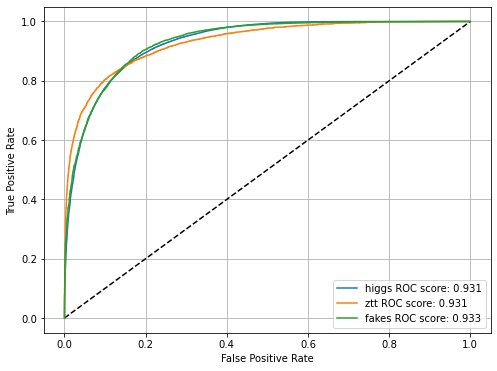

In [45]:
classes = ['higgs', 'ztt', 'fakes']
fig, ax = plt.subplots(figsize=(8,6))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('/signal_background/eda/roc_curves.png')

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


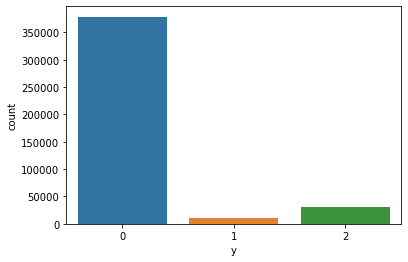

In [50]:
sns.countplot(y_test)
plt.show()

In [42]:
write_auc('with_iso', roc_auc)

In [46]:
cr = classification_report(y_test, xgb_clf_iso.predict(X_test), output_dict=True, target_names=classes, sample_weight=w_test)
pd.DataFrame(cr).transpose()

,precision,recall,f1-score,support
higgs,0.507753,0.051736,0.093905,279.545650
ztt,0.824165,0.681000,0.745774,11039.960088
fakes,0.915571,0.964197,0.939255,40836.150000
accuracy,0.899361,0.899361,0.899361,0.899361
macro avg,0.749163,0.565644,0.592978,52155.655738
weighted avg,0.894037,0.899361,0.893769,52155.655738


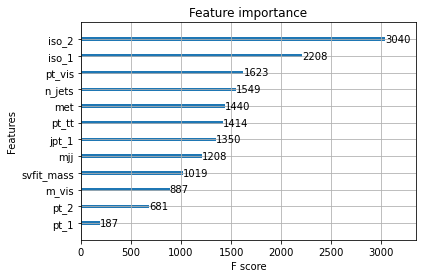

In [51]:
xgboost.plot_importance(xgb_clf_iso).set_yticklabels(df_2.drop(['y','wt','w','cn'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_weight_with_iso.png')
plt.show()

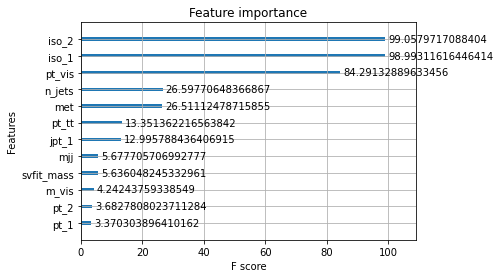

In [52]:
xgboost.plot_importance(xgb_clf_iso, importance_type='gain').set_yticklabels(df_2.drop(['y','wt','w','cn'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_gain_with_iso.png')
plt.show()

Normalised purity confusion matrix
[[0.50775292 0.0157093  0.00283175]
 [0.44485153 0.82416512 0.08159705]
 [0.04739556 0.16012558 0.9155712 ]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/purity_with_iso.png
Normalised efficiency confusion matrix
[[5.17363563e-02 5.12630517e-01 4.35633126e-01]
 [1.14774057e-03 6.80999874e-01 3.17852385e-01]
 [3.30589441e-05 3.57697775e-02 9.64197164e-01]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/efficiency_with_iso.png


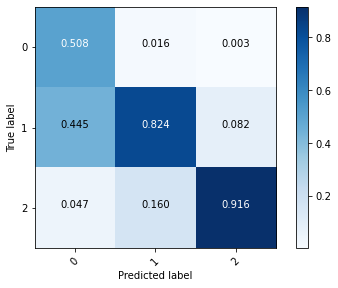

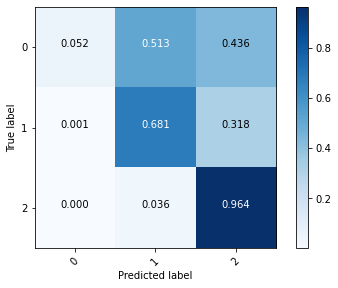

In [47]:
predict=xgb_clf_iso.predict(X_test)
cm_p=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_row=True, w_test=w_test, figname=f'{write_path}purity_with_iso.png')
cm_e=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_col=True, w_test=w_test, figname=f'{write_path}efficiency_with_iso.png')

In [48]:
y_pred = xgb_clf_iso.predict_proba(X_test)

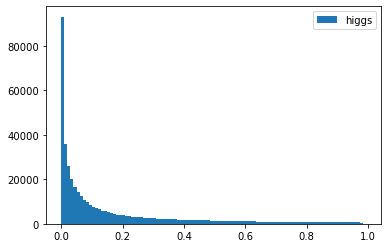

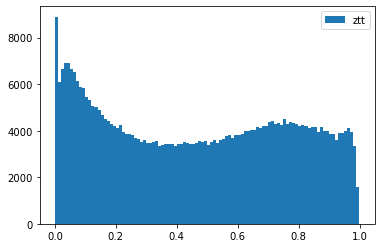

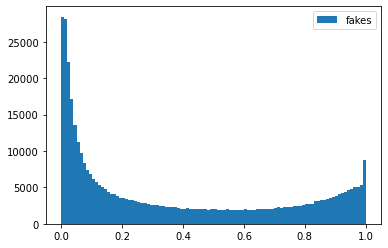

In [49]:
plt.figure()
plt.hist(y_pred[:, 0], bins=100, label='higgs')
plt.legend()
plt.figure()
plt.hist(y_pred[:, 1], bins=100, label='ztt')
plt.legend()
plt.figure()
plt.hist(y_pred[:, 2], bins=100, label='fakes')
plt.legend()
plt.show()

In [47]:
write_cm('with_iso', cm_p, cm_e)

# use smote on with iso config

In [48]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

In [49]:
df_2 = df.drop(selectors, axis=1)

In [50]:
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf_iso_smote = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()

In [51]:
df_2.drop(['y', 'wt', 'w'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'iso_1', 'iso_2'],
      dtype='object')

In [52]:
X = df_2.drop(['y', 'wt', 'w'], axis=1).to_numpy()
y = df_2.y.astype(int)
w = df_2.w
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.3, random_state=1, stratify=df_2.y)

In [57]:
smote_enn = SMOTEENN(random_state=0)
# X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
X_resampled, y_resampled = smote_enn.fit_resample(np.c_[X_train, w_train], y_train)

In [60]:
X_resampled.shape

(2457407, 13)

In [61]:
X_resampled[:]

(977937, 12)

In [ ]:
X_m = 
w_m = 

In [84]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf_iso.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss", sample_weight_eval_set=(w_train, w_test))
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:40:21] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.06526	validation_1-mlogloss:1.06547
[2]	validation_0-mlogloss:1.00649	validation_1-mlogloss:1.00734
[4]	validation_0-mlogloss:0.95643	validation_1-mlogloss:0.95769
[6]	validation_0-mlogloss:0.91341	validation_1-mlogloss:0.91518
[8]	validation_0-mlogloss:0.87607	validation_1-mlogloss:0.87821
[10]	validation_0-mlogloss:0.84383	validation_1-mlogloss:0.84634
[12]	validation_0-mlogloss:0.81541	validation_1-mlogloss:0.81831
[14]	validation_0-mlogloss:0.79055	validation_1-mlogloss:0.79370
[16]	validation_0-mlogloss:0.76881	validation_1-mlogloss:0.77226
[18]	validation_0-mlogloss:0.74965	validation_1-mlogloss:0.75338
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
eval_set = [(X_resampled, y_resampled), (X_test, y_test)]
xgb_clf_c.fit(X_resampled, y_resampled, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss", sample_weight_eval_set=(w_train, w_test))


In [104]:
df_1.loc[:, 'y_pred']  = xgb_clf.predict(X)

In [114]:
df_1.drop(['y', 'wt'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'w', 'y_pred'],
      dtype='object')

In [148]:
df_test = pd.DataFrame(X_test, columns=df_1.drop(['y', 'wt'], axis=1).columns).reset_index(drop=True)

In [147]:
(y_test==2).sum()

20166

In [149]:
df_test['y'] = y_test.to_numpy()
df_test['w'] = w_test.to_numpy()

In [150]:
df_test['y_pred'] = xgb_clf.predict(X_test)

In [151]:
df_test

,pt_1,pt_2,m_vis,svfit_mass,mjj,jpt_1,pt_tt,met,n_jets,pt_vis,w,y,y_pred
0,92.282034,53.676795,92.767455,115.830387,777.012285,111.839663,138.882213,29.351910,2.0,114.518214,0.000053,0,0
1,41.703584,40.880400,85.186898,101.254921,507.899335,98.537312,23.169485,24.799908,2.0,2.083170,0.000024,0,0
2,129.497680,81.550319,92.653429,124.638680,2601.815534,256.477620,283.144277,88.702454,4.0,195.046717,0.000063,0,0
3,42.768679,40.478256,83.106576,139.588425,970.733272,75.777211,81.928694,77.720337,1.0,6.513472,0.000157,0,0
4,52.635335,52.384945,101.074869,108.849537,169.383822,41.276124,30.110152,9.723588,3.0,39.826468,0.000056,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198848,86.956464,54.072191,84.667066,98.186611,491.818811,143.600868,144.432830,30.410059,2.0,118.070496,0.000057,0,0
198849,54.342384,50.044678,106.130171,142.722984,-9999.000000,38.905858,51.391301,56.381241,1.0,5.797828,0.000154,0,0
198850,332.635573,71.107560,85.773144,124.196709,809.351633,787.601410,691.283480,294.794250,2.0,396.512134,0.000135,0,0
198851,66.861926,42.956125,105.681926,125.633175,364.414807,94.597766,77.411184,12.334446,3.0,67.925730,0.000063,0,0
